![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 13 - Attention and Transformers </center>
### <center> Transformers </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers/MainTransformer.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/13_AttentionAndTransfomers/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn            as nn
import torch.optim         as optim
import torchinfo
import torchtext

from torchtext.vocab import Vocab

### Transformer
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Transformer.png?raw=true" alt="Transformer" width=800>

#### Transformer = Encode + Decoder

In [5]:
dEmbbeding    = 256
nHead         = 8
nEncoderLayer = 3
nDecoderLayer = 4
dNN           = 512

oTransformer  = nn.Transformer(dEmbbeding, nHead, nEncoderLayer, nDecoderLayer, dNN)
torchinfo.summary(oTransformer)

Layer (type:depth-idx)                                            Param #
Transformer                                                       --
├─TransformerEncoder: 1-1                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          527,104
│    │    └─TransformerEncoderLayer: 3-2                          527,104
│    │    └─TransformerEncoderLayer: 3-3                          527,104
│    └─LayerNorm: 2-2                                             512
├─TransformerDecoder: 1-2                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerDecoderLayer: 3-4                          790,784
│    │    └─TransformerDecoderLayer: 3-5                          790,784
│    │    └─TransformerDecoderLayer: 3-6                          790,784
│    │    └─TransformerDecoderLayer: 3-7                          7

#### Encoder = [EncoderLayer] * `nEncoderLayer`

In [6]:
torchinfo.summary(oTransformer.encoder)

Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          263,168
│    │    └─Linear: 3-2                                      131,584
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      131,328
│    │    └─LayerNorm: 3-5                                   512
│    │    └─LayerNorm: 3-6                                   512
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          263,168
│    │    └─Linear: 3-10                                     131,584
│    │  

##### Decoder = [DecoderLayer] * `nDecoderLayer`

In [7]:
torchinfo.summary(oTransformer.decoder)

Layer (type:depth-idx)                                       Param #
TransformerDecoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerDecoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          263,168
│    │    └─MultiheadAttention: 3-2                          263,168
│    │    └─Linear: 3-3                                      131,584
│    │    └─Dropout: 3-4                                     --
│    │    └─Linear: 3-5                                      131,328
│    │    └─LayerNorm: 3-6                                   512
│    │    └─LayerNorm: 3-7                                   512
│    │    └─LayerNorm: 3-8                                   512
│    │    └─Dropout: 3-9                                     --
│    │    └─Dropout: 3-10                                    --
│    │    └─Dropout: 3-11                                    --
│    └─Trans

#### Load the data:

In [8]:
import re

def NormalizeEnglish(line):
    line = line.lower().strip()
    line = re.sub(r"([.!?])", r" \1",     line) #-- add space before [.!?]
    line = re.sub(r"[^a-zA-Z.!?]+", r" ", line) #-- keep only letters and [.!?]
    return line

def NormalizeHebrew(line):
    line = line.strip()
    line = re.sub(r"([.!?])", r" \1",            line)
    line = re.sub(r"[^\u0590-\u05fe.!?]+", r" ", line)
    return line

dirPath = '../../data/Translation//'
lLines  = []
with open(dirPath + 'heb.txt', encoding='utf-8') as oFile:
    for line in oFile:
        lSplit  = line.split('\t')[:2]
        lLines += [(NormalizeEnglish(lSplit[0]), NormalizeHebrew(lSplit[1]))]

N = len(lLines)
N, lLines[26600:26605]

(126692,
 [('tom found evidence .', 'תום מצא ראיות .'),
  ('tom freed the bird .', 'טום שחרר את הציפור .'),
  ('tom freed the bird .', 'טום שלח את הציפור לחופשי .'),
  ('tom gasped for air .', 'תום נאבק לנשום .'),
  ('tom gets headaches .', 'תום מקבל כאבי ראש .')])

#### Build vocabularies:

In [9]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lLines):
    for line in lLines:
        yield line.split()

def MakeVocab(lLines):
    oVocab = build_vocab_from_iterator(YieldTokens(lLines), min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    oVocab.set_default_index(oVocab['<UNK>'])
    return oVocab
        
lEnglish, lHebrew = zip(*lLines)
oEngVocab         = MakeVocab(lEnglish)
oHebVocab         = MakeVocab(lHebrew)

len(oEngVocab), len(oHebVocab)

(7506, 16272)

#### Line2Tensor:

In [10]:
def Line2Tensor(oVocab, line):
    lLine = ['<SOS>'] + line.split() + ['<EOS>']
    return torch.tensor(oVocab(lLine))

def Tensor2Line(oVocab, vLine):
    return ' '.join([oVocab.get_itos()[e] for e in vLine])
    
#-- Test:
eng1 = lEnglish[152]
heb1 = lHebrew [152]
eng2 = Line2Tensor(oEngVocab, eng1)
heb2 = Line2Tensor(oHebVocab, heb1)
eng3 = Tensor2Line(oEngVocab, eng2)
heb3 = Tensor2Line(oHebVocab, heb2)

print(f'Origianl (Eng) - {eng1}')
print(f'Origianl (Heb) - {heb1}')
print(f'Tensor   (Eng) - {eng2}')
print(f'Tensor   (Heb) - {heb2}')
print(f'Back     (Eng) - {eng3}')
print(f'Back     (Heb) - {heb3}')

Origianl (Eng) - hold it !
Origianl (Heb) - עצור !
Tensor   (Eng) - tensor([  1, 543,  14, 111,   2])
Tensor   (Heb) - tensor([   1, 1736,   44,    2])
Back     (Eng) - <SOS> hold it ! <EOS>
Back     (Heb) - <SOS> עצור ! <EOS>


#### Dataset:

In [11]:
if False:
    class LangDataset(torch.utils.data.Dataset):
        def __init__(self, lX, lY, oVocabX, oVocabY):
            self.lX      = lX
            self.lY      = lY
            self.oVocabX = oVocabX
            self.oVocabY = oVocabY

        def __len__(self):
            return len(self.lX)

        def __getitem__(self, idx):
            sX = self.lX[idx]
            sY = self.lY[idx]

            vX = Line2Tensor(self.oVocabX, sX)
            vY = Line2Tensor(self.oVocabY, sY)

            return vX, vY

In [12]:
from DeepLearningFramework.TransformerUtils import LangDataset

oDataset           = LangDataset(lEnglish, lHebrew, oEngVocab, oHebVocab)
vEngLine, vHebLine = oDataset[155]

Tensor2Line(oEngVocab, vEngLine), Tensor2Line(oHebVocab, vHebLine)

('<SOS> hug tom . <EOS>', '<SOS> <UNK> את תום . <EOS>')

In [13]:
from torch.utils.data import random_split

nTrain              = 115000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(115000, 11692)

#### Data loader:

In [14]:
from torch.nn.utils.rnn import pad_sequence

oVocabX = oEngVocab
oVocabY = oHebVocab
if False:
    class LangCollate:
        def __init__(self, padValue):
            self.padValue = padValue

        def __call__(self, lBatch):
            lX, lY = zip(*lBatch)
            mX     = pad_sequence(lX, padding_value=self.padValue, batch_first=True)
            mY     = pad_sequence(lY, padding_value=self.padValue, batch_first=True)

            return mX, mY

In [15]:
from DeepLearningFramework.TransformerUtils import LangCollate
from torch.utils.data                       import DataLoader

oCollate  = LangCollate(oVocabX['<PAD>'])
batchSize = 128
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=oCollate, num_workers=2, persistent_workers=True)
oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=oCollate, num_workers=2, persistent_workers=True)

mX, mY = next(iter(oTrainDL))
mX.shape, mY.shape

(torch.Size([128, 18]), torch.Size([128, 17]))

#### Transformer:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/13_AttentionAndTransfomers//Transformer.png?raw=true" alt="Transformer" width=800>

In [16]:
Vx   = len(oVocabX)
Vy   = len(oVocabY)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        D                   = 256
        MAX_LENGTH          = 55
        self.oEmbeedingX    = nn.Embedding  (Vx,         D)
        self.oEmbeedingY    = nn.Embedding  (Vy,         D)
        self.oEmbeedingPosX = nn.Embedding  (MAX_LENGTH, D)
        self.oEmbeedingPosY = nn.Embedding  (MAX_LENGTH, D)
        self.oTransformer   = nn.Transformer(D, 8, 3, 3, 2*D, 0.15, batch_first=True)
        self.oLinear        = nn.Linear     (D, Vy)
    #-------------------------------------------------------------------------------#    
    #-------------------------------------------------------------------------------#
    def PreEncode(self, mX):
        mMask     = mX == oVocabX['<PAD>']             #-- mMask.shape = (N, Tx)
        mX        = self.oEmbeedingX(mX)               #-- mX   .shape = (N, Tx, D)
        N, Tx, D  = mX.shape
        vT        = torch.arange(Tx, device=mX.device) #-- vT   .shape = (Tx,)
        mT        = self.oEmbeedingPosX(vT[None,:])    #-- mT   .shape = (1, Tx, D)
        mX        = np.sqrt(D) * mX + mT               #-- mX   .shape = (N, Tx, D)
        
        return mX, mMask
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def PreDecode(self, mY):
        mMask     = mY == oVocabY['<PAD>']             #-- mMask.shape = (N, Ty)
        mY        = self.oEmbeedingY(mY)               #-- mY   .shape = (N, Ty, D)
        N, Ty, D  = mY.shape
        vT        = torch.arange(Ty, device=mY.device) #-- vT   .shape = (Ty,)
        mT        = self.oEmbeedingPosY(vT[None,:])    #-- mT   .shape = (1, Ty, D)
        mY        = np.sqrt(D) * mY + mT               #-- mY   .shape = (N, Ty, D)
        
        mSubMask  = self.oTransformer.generate_square_subsequent_mask(Ty).to(mY.device) #-- mSubMask.shape = (Ty, Ty)
        
        return mY, mMask, mSubMask
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def Encode(self, mX):
        #-- mX.shape = (N, Tx)
        mX, mMaskX = self.PreEncode(mX)                                         #-- mX.shape = (N, Tx, D)
        mH         = self.oTransformer.encoder(mX, src_key_padding_mask=mMaskX) #-- mH.shape = (N, Tx, D)
    
        return mH, mMaskX
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def Decoce(self, mH, mMaskH, mY):
        #-- mY.shape = (N, Ty, D)
        mY, mMaskY, mSubMaskY = self.PreDecode(mY)
        
        mO = self.oTransformer.decoder(mY, mH,
                                   memory_key_padding_mask = mMaskH,   #-- H padding mask (same as X)
                                   tgt_key_padding_mask    = mMaskY,   #-- Y padding mask
                                   tgt_mask                = mSubMaskY #-- Y time    mask
                                  )                                    #-- mO.shape = (N, Ty, D)
        mZ = self.oLinear(mO)  #-- mZ.shape = (N, Ty, Vy)
        mZ = mZ.permute(0,2,1) #-- mZ.shape = (N, Vy, Ty)
    
        return mZ
    #-------------------------------------------------------------------------------#
    #-------------------------------------------------------------------------------#
    def forward(self, mX, mY):
        mH, mMaskX = self.Encode(mX)
        mZ         = self.Decoce(mH, mMaskX, mY)
        
        return mZ

In [17]:
oModel = Transformer()
mZ     = oModel(mX, mY[:,:-1])
mZ.shape

torch.Size([128, 16272, 16])

In [18]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, mY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        mY = mY.to(DEVICE)
        
        if bTrain == True:
            #-- Forward:
            mOut = oModel(mX,   mY[:,:-1]) #-- omit <EOS>
            loss = Loss  (mOut, mY[:,1:])  #-- omit <SOS>

            #-- Backward:
            vLR[ii] = oScheduler.get_last_lr()[0]
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Forward:
                mOut = oModel(mX,   mY[:,:-1]) #-- omit <EOS>
                loss = Loss  (mOut, mY[:,1:])  #-- omit <SOS>

        with torch.no_grad():
            Nb           = mY.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mY[:,1:])
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [19]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device       ('cuda:0' if torch.cuda.is_available() else 'cpu') 
Loss   = nn.CrossEntropyLoss(ignore_index=oVocabY['<PAD>'])
Metric = Accuracy           (ignoreIndex =oVocabY['<PAD>'])

In [20]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = Transformer().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=5e-1)
oScheduler = OneCycleLR (oOptim, max_lr=8e-4, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='Transformer');

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  5.941 | Val loss:  4.975 | Train Metric:  0.320 | Val Metric:  0.382 | epoch time: 27.113 | <-- Checkpoint!
Epoch 001: | Train loss:  4.790 | Val loss:  4.579 | Train Metric:  0.399 | Val Metric:  0.418 | epoch time: 22.593 | <-- Checkpoint!
Epoch 002: | Train loss:  4.444 | Val loss:  4.250 | Train Metric:  0.426 | Val Metric:  0.444 | epoch time: 22.490 | <-- Checkpoint!
Epoch 003: | Train loss:  4.151 | Val loss:  3.970 | Train Metric:  0.449 | Val Metric:  0.467 | epoch time: 22.638 | <-- Checkpoint!
Epoch 004: | Train loss:  3.876 | Val loss:  3.702 | Train Metric:  0.469 | Val Metric:  0.489 | epoch time: 23.148 | <-- Checkpoint!
Epoch 005: | Train loss:  3.608 | Val loss:  3.454 | Train Metric:  0.490 | Val Metric:  0.510 | epoch time: 22.803 | <-- Checkpoint!
Epoch 006: | Train loss:  3.345 | Val loss:  3.198 | Train Metric:  0.512 |

Epoch 059: | Train loss:  0.878 | Val loss:  1.504 | Train Metric:  0.798 | Val Metric:  0.716 | epoch time: 39.032 |
------------------------------------------------------------------------------------------------------------------------
Epoch 060: | Train loss:  0.864 | Val loss:  1.481 | Train Metric:  0.801 | Val Metric:  0.719 | epoch time: 38.974 | <-- Checkpoint!
Epoch 061: | Train loss:  0.851 | Val loss:  1.491 | Train Metric:  0.804 | Val Metric:  0.720 | epoch time: 38.977 | <-- Checkpoint!
Epoch 062: | Train loss:  0.836 | Val loss:  1.504 | Train Metric:  0.807 | Val Metric:  0.719 | epoch time: 39.065 |
Epoch 063: | Train loss:  0.821 | Val loss:  1.495 | Train Metric:  0.810 | Val Metric:  0.720 | epoch time: 39.336 | <-- Checkpoint!
Epoch 064: | Train loss:  0.807 | Val loss:  1.487 | Train Metric:  0.813 | Val Metric:  0.720 | epoch time: 39.392 | <-- Checkpoint!
Epoch 065: | Train loss:  0.792 | Val loss:  1.494 | Train Metric:  0.816 | Val Metric:  0.721 | epoch time

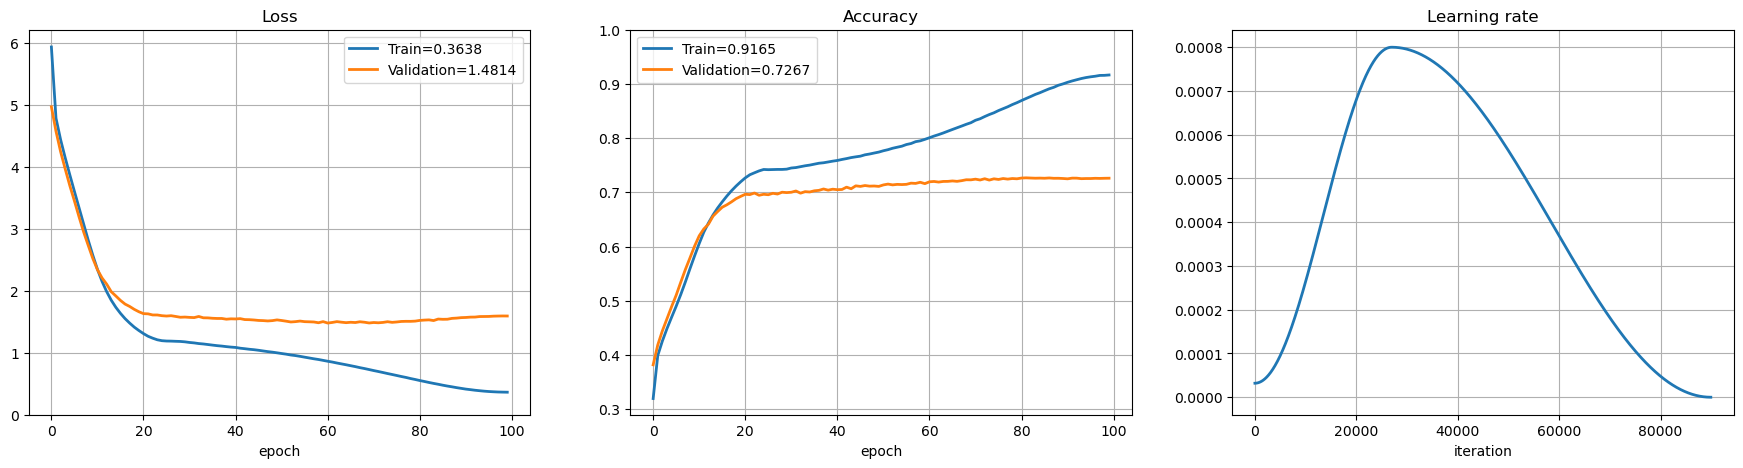

In [21]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [22]:
# oModel = Transformer  ()
# oModel.load_state_dict(torch.load('Transformer_v1.pt'))
# oModel.to             (DEVICE)
# oModel.train          (False)

### Exercise (predict implementation)
Complete the `Predict` function implementation.  

Note: A [beam search](https://en.wikipedia.org/wiki/Beam_search) should be used instead of top 1 method.

In [ ]:
from torch.distributions.categorical import Categorical

def Predict(oModel, vX, bTop1=False):
    MAX_LENGTH = 16
    vY         = oVocabY['<PAD>'] * torch.ones(MAX_LENGTH, dtype=torch.int32, device=vX.device)
    vY[0]      = oVocabY['<SOS>']
    #-- Encode:
    mH, mMaskX = ???

    for ii in range(1, MAX_LENGTH):
        #-- Decode:
        vZ = ???
        
        if bTop1 == True:
            y = ???
        else:
            y = ???

        vY[ii] = y
        
        if y == ???
            break

    return ???

In [23]:
from torch.distributions.categorical import Categorical

def Predict(oModel, vX, bTop1=False):
    MAX_LENGTH = 16
    vY         = oVocabY['<PAD>'] * torch.ones(MAX_LENGTH, dtype=torch.int32, device=vX.device)
    vY[0]      = oVocabY['<SOS>']
    #-- Encode:
    mH, mMaskX = oModel.Encode(vX[None,:])

    for ii in range(1, MAX_LENGTH):
        #-- Decode:
        vZ = oModel.Decoce(mH, mMaskX, vY[None,:ii])[0,:,-1]
        
        if bTop1 == True:
            y = vZ.argmax()
        else:
            y = Categorical(logits=vZ).sample()

        vY[ii] = y
        
        if y == oVocabY['<EOS>']:
            break

    return vY[1:ii]

In [24]:
dLang = pd.DataFrame(index=range(5), columns=['English', 'GT (Hebrew)', 'Generated'])

for ii in range(5):
    idx        = np.random.randint(nTest)
    vEng, vHeb = oTestSet[idx]
    vEng       = vEng.to(DEVICE)
    with torch.no_grad():
        vHebOut = Predict(oModel, vEng, bTop1=True)

    sEng             = Tensor2Line(oEngVocab, vEng[1:-1])
    sHeb             = Tensor2Line(oHebVocab, vHeb[1:-1])
    sHebHat          = Tensor2Line(oHebVocab, vHebOut)
    dLang.iloc[ii,:] = [sEng, sHeb, sHebHat]

dLang

,English,GT (Hebrew),Generated
0,tom tried to attract mary s attention .,תום ניסה למשוך את תשומת ליבה של מרי .,תום ניסה למשוך תשומת לב <UNK> של מרי .
1,it just doesn t seem fair .,זה פשוט לא נראה הוגן .,זה לא נראה הוגן .
2,what is it you re looking for ?,מה אתה מחפש ?,מה זה שאתה מחפש ?
3,i speak french to my staff .,אני מדבר צרפתית עם הפועלים שלי .,אני מדברת צרפתית עם <UNK> שלי .
4,that child is impossible .,הילד הזה בלתי נסבל .,הילד הזה בלתי אפשרי .


In [31]:
line = 'Write here your line!'
line = NormalizeEnglish(line)
vEng = Line2Tensor(oEngVocab, line).to(DEVICE)
with torch.no_grad():
    vHebOut = Predict(oModel, vEng, bTop1=False)
    
sHebPred = Tensor2Line(oHebVocab, vHebOut)    
sHebPred

'תכתוב פה את השורה שלך !'

In [ ]:
# from torch.distributions.categorical import Categorical

# def Predict(oModel, vX, bTop1=False):
#     MAX_LENGTH = 16
#     vY         = oVocabY['<PAD>'] * torch.ones(MAX_LENGTH, dtype=torch.int32, device=vX.device)
#     vY[0]      = oVocabY['<SOS>']
#     #-- Encode:
#     mH, mMaskX = oModel.Encode(vX[None,:])

#     for ii in range(1, MAX_LENGTH):
#         #-- Decode:
#         vZ = oModel.Decoce(mH, mMaskX, vY[None,:ii])[0,:,-1]
        
#         if bTop1 == True:
#             y = vZ.argmax()
#         else:
#             y = Categorical(logits=vZ).sample()

#         vY[ii] = y
        
#         if y == oVocabY['<EOS>']:
#             break

#     return vY[1:ii]